
Day 6: Raster Map of Brazil 

Description:
This map visualizes the topography of Brazil using the NE1_HR_LC raster dataset clipped to Brazil’s boundaries. Elevation values are displayed using the “terrain” colormap, which provides a natural and intuitive gradient to represent elevation. A basemap from CartoDB Voyager was added for geographic context, and Brazil’s boundary is outlined with a dashed black line for clarity. The map also includes a colorbar for interpreting elevation values.

Design Considerations:
	•	The terrain colormap was chosen for its natural representation of elevation, ensuring the map is intuitive and visually appealing.
	•	A basemap (CartoDB Voyager) was included to provide geographic context, highlighting Brazil’s location in relation to surrounding areas.
	•	Brazil’s boundary was styled with a dashed black line to create contrast with the basemap and raster visualization.
	•	The font was set to Serif, adding a touch of professionalism and readability to the labels and title.
	•	The colorbar was positioned vertically and includes clear labels to make the elevation values easy to interpret.
	•	Gridlines were styled with a subtle gray to add structure without overwhelming the visual elements.

Goals:
	•	Showcase the elevation of Brazil in an analytical yet visually engaging way.
	•	Provide geographic context using a basemap while keeping the elevation as the central focus.
	•	Create a polished and professional map suitable for presentations or analysis.

Dataset Source

The raster dataset used in this map, NE1_HR_LC, was downloaded from the Natural Earth Raster Datasets.
https://www.naturalearthdata.com/downloads/10m-raster-data/10m-natural-earth-1/

Natural Earth 1, large (or medium) dataset used. 

 This dataset combines land cover and shaded relief imagery, making it ideal for global or regional topographic visualizations.

Summary

This map combines topographic raster data, boundary geometry, and a professional cartographic style to highlight Brazil’s elevation. By using a clear colormap, readable labels, and a contextual basemap, the map achieves a balance of aesthetic appeal and analytical clarity.

/var/folders/41/93fvfx5910ldvs4p20rv5w540000gn/T/ipykernel_40407/843395170.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


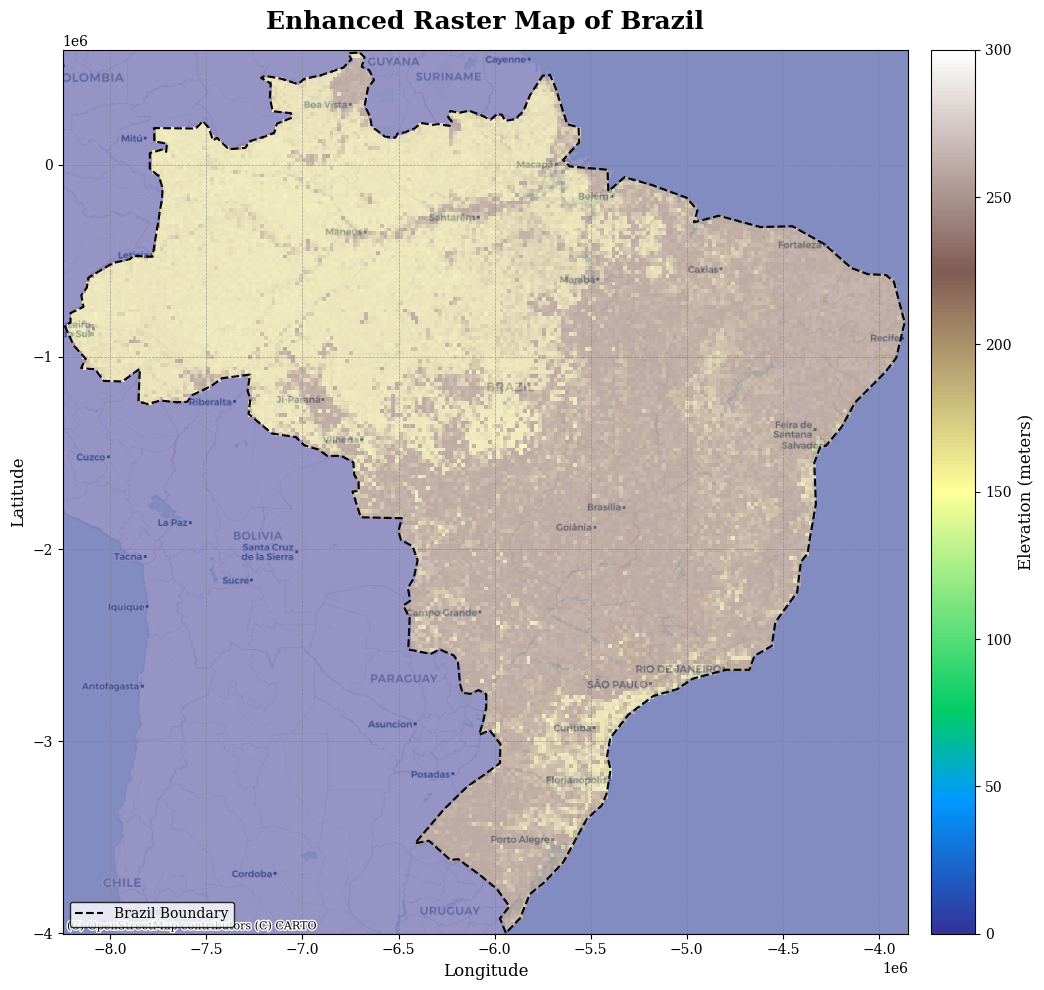

In [2]:
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import contextily as ctx
from matplotlib import rcParams
from matplotlib import font_manager as fm


rcParams['font.family'] = 'Serif'


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
brazil = world[world['name'] == 'Brazil']
brazil = brazil.to_crs(epsg=3857)


raster_path = "/Users/macytrout/Desktop/NE1_HR_LC.tif"
reprojected_raster_path = "/Users/macytrout/Desktop/reprojected_raster.tif"

with rasterio.open(raster_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, 'EPSG:3857', src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': 'EPSG:3857',
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(reprojected_raster_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs='EPSG:3857',
                resampling=Resampling.nearest)


with rasterio.open(reprojected_raster_path) as src:
    out_image, out_transform = mask(src, brazil.geometry, crop=True)


fig, ax = plt.subplots(figsize=(12, 10))
raster_extent = [
    out_transform[2],
    out_transform[2] + out_transform[0] * out_image.shape[2],
    out_transform[5] + out_transform[4] * out_image.shape[1],
    out_transform[5],
]
raster_plot = ax.imshow(out_image[0], cmap="terrain", extent=raster_extent, norm=Normalize(vmin=0, vmax=300))


brazil.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5, linestyle="--", label="Brazil Boundary")


ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, zoom=5, alpha=0.5)


ax.set_title("Enhanced Raster Map of Brazil", fontsize=18, fontweight="bold", pad=15, color="black")
ax.set_xlabel("Longitude", fontsize=12, color="black")
ax.set_ylabel("Latitude", fontsize=12, color="black")
ax.legend(loc="lower left", fontsize=10, frameon=True, facecolor="white", edgecolor="black")


cbar = fig.colorbar(raster_plot, ax=ax, orientation="vertical", pad=0.02)
cbar.set_label("Elevation (meters)", fontsize=12, color="black")
cbar.ax.yaxis.set_tick_params(color="black")
plt.setp(cbar.ax.yaxis.get_ticklabels(), color="black")


ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)


plt.tight_layout()
plt.show()